### 와인 데이터세트로 딥러닝 분류, FC만 이용

Epoch [ 10/100] | Loss: 0.3247 | Train Acc: 95.16% | Test Acc: 98.15%
Epoch [ 20/100] | Loss: 0.0583 | Train Acc: 99.19% | Test Acc: 100.00%
Epoch [ 30/100] | Loss: 0.0299 | Train Acc: 99.19% | Test Acc: 100.00%
Epoch [ 40/100] | Loss: 0.0084 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch [ 50/100] | Loss: 0.0056 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch [ 60/100] | Loss: 0.0066 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch [ 70/100] | Loss: 0.0053 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch [ 80/100] | Loss: 0.0088 | Train Acc: 100.00% | Test Acc: 100.00%
Epoch [ 90/100] | Loss: 0.0027 | Train Acc: 100.00% | Test Acc: 98.15%
Epoch [100/100] | Loss: 0.0007 | Train Acc: 100.00% | Test Acc: 100.00%
최종 훈련 정확도: 100.00%
최종 테스트 정확도: 100.00%


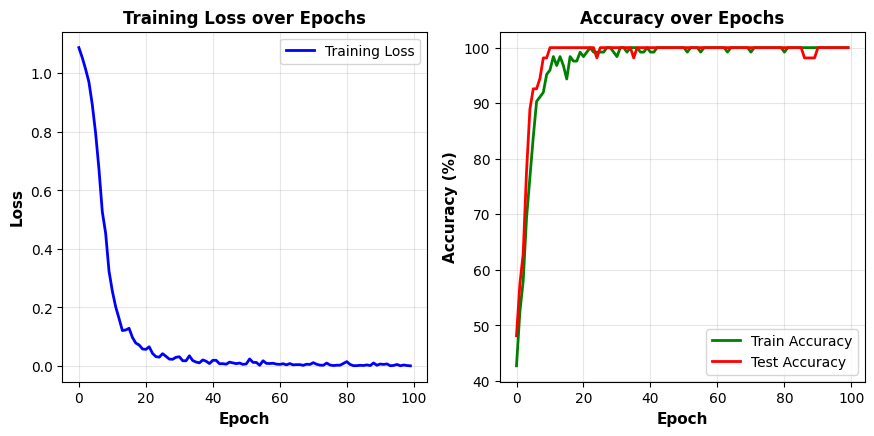

In [2]:
# ============================================================================
# 와인 데이터셋을 활용한 딥러닝 분류 (Fully Connected Layer만 사용)
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1. 데이터 로딩 및 전처리
data = load_wine()
X = StandardScaler().fit_transform(data.data)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# PyTorch 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


# 2. FC 신경망 모델 정의
class FCNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FCNetwork, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Hidden Layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_size = hidden_size
        
        # Output Layer
        layers.append(nn.Linear(prev_size, output_size))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# 3. 모델 초기화
input_size = X_train.shape[1]  # 13
hidden_sizes = [64, 32, 16]    # 3개의 FC 레이어
output_size = len(np.unique(y))  # 3

model = FCNetwork(input_size, hidden_sizes, output_size)

# 4. 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 5. 학습
epochs = 100
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 통계
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    # 평균 손실 및 정확도
    avg_loss = epoch_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    # 테스트 정확도
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_acc = 100 * (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:3d}/{epochs}] | Loss: {avg_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")


# 6. 최종 평가
model.eval()
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    _, train_predicted = torch.max(train_outputs.data, 1)
    final_train_acc = accuracy_score(y_train, train_predicted.numpy())
    
    test_outputs = model(X_test_tensor)
    _, test_predicted = torch.max(test_outputs.data, 1)
    final_test_acc = accuracy_score(y_test, test_predicted.numpy())

print(f"최종 훈련 정확도: {final_train_acc * 100:.2f}%")
print(f"최종 테스트 정확도: {final_test_acc * 100:.2f}%")


# 7. 시각화
fig = plt.figure(figsize=(16, 10))

# Subplot 1: 학습 손실
plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.xlabel('Epoch', fontsize=11, fontweight='bold')
plt.ylabel('Loss', fontsize=11, fontweight='bold')
plt.title('Training Loss over Epochs', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: 정확도 비교
plt.subplot(2, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green', linewidth=2)
plt.plot(test_accuracies, label='Test Accuracy', color='red', linewidth=2)
plt.xlabel('Epoch', fontsize=11, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
plt.title('Accuracy over Epochs', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
